### Import libraries

In [1]:
import torch
import warnings
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import albumentations as A

from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from datasets.gta5 import GTA5
from datasets.cityscapes import CityScapes
from torchvision.transforms import ToPILImage
from albumentations.pytorch import ToTensorV2

from utils import fast_hist, per_class_iou
from models.bisenet.build_bisenet import BiSeNet

warnings.filterwarnings("ignore")

### Training - Augmentation 1

In [2]:
# Define the polynomial learning rate scheduler
def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1, max_iter=300, power=0.9):
    lr = init_lr * (1 - iter / max_iter) ** power
    optimizer.param_groups[0]['lr'] = lr
    return lr

# Set the device
device = torch.device("cuda")
# Load model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
# Set model to training mode
model.train()

# Define the custom transform to augment the data
custom_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.5),
    ToTensorV2()
])

# Load the dataset
dataset = GTA5(root_dir='datasets/GTA5', custom_transform=custom_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=255)
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Set model to training mode
model.train()
# Training loop
for epoch in range(50):
    hist = np.zeros((19, 19))
    # Iterate over the dataset
    for i, (images, labels) in enumerate(tqdm(dataloader)):
        # Move the data to the device
        images = images.to(device)
        label = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(images)[0]
        # Compute the loss
        loss = criterion(output, label)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Compute the predictions
        pred = output.argmax(dim=1)

        # Calculate the mean IoU
        hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
        miou = np.mean(per_class_iou(hist))

    # Update the learning rate
    poly_lr_scheduler(optimizer, 0.001, epoch, max_iter=len(dataloader))

    # Print the loss and mIoU
    print(f'Epoch: {epoch}, Loss: {loss.item()}, mIoU: {miou}')

# Save the model
torch.save(model.state_dict(), 'models/bisenet/bisenet_step3b/bisenet_gta5_aug_1.pth')

100%|██████████| 313/313 [02:23<00:00,  2.19it/s]


Epoch: 0, Loss: 0.49920350313186646, mIoU: 0.17708001827989245


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]


Epoch: 1, Loss: 0.6166661381721497, mIoU: 0.23963895407391914


100%|██████████| 313/313 [02:23<00:00,  2.19it/s]


Epoch: 2, Loss: 0.4317372739315033, mIoU: 0.25939390478872276


100%|██████████| 313/313 [02:16<00:00,  2.29it/s]


Epoch: 3, Loss: 0.5361282229423523, mIoU: 0.2757499365729038


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]


Epoch: 4, Loss: 0.4721938371658325, mIoU: 0.29597974480272915


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 5, Loss: 0.599724531173706, mIoU: 0.30986610105869794


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 6, Loss: 0.367703378200531, mIoU: 0.3232279481278177


100%|██████████| 313/313 [02:17<00:00,  2.28it/s]


Epoch: 7, Loss: 0.44141659140586853, mIoU: 0.33944888429989484


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 8, Loss: 0.3028569221496582, mIoU: 0.35152194888590604


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 9, Loss: 0.3782123923301697, mIoU: 0.3534546389861844


100%|██████████| 313/313 [02:17<00:00,  2.28it/s]


Epoch: 10, Loss: 0.2848290801048279, mIoU: 0.35819740304028214


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 11, Loss: 0.3204677402973175, mIoU: 0.37739282165482796


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 12, Loss: 0.5239871740341187, mIoU: 0.383893583326722


100%|██████████| 313/313 [02:18<00:00,  2.26it/s]


Epoch: 13, Loss: 0.3492736220359802, mIoU: 0.399045456870739


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 14, Loss: 0.4391728341579437, mIoU: 0.39882928565926085


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 15, Loss: 0.30282577872276306, mIoU: 0.40515400218833597


100%|██████████| 313/313 [02:16<00:00,  2.29it/s]


Epoch: 16, Loss: 0.34287339448928833, mIoU: 0.41225538907795717


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 17, Loss: 0.2989545464515686, mIoU: 0.4210696966833105


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 18, Loss: 0.37003955245018005, mIoU: 0.4241350202972248


100%|██████████| 313/313 [02:17<00:00,  2.27it/s]


Epoch: 19, Loss: 0.2597728669643402, mIoU: 0.4229373865391805


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


Epoch: 20, Loss: 0.19002340734004974, mIoU: 0.4311096464394894


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 21, Loss: 0.22866778075695038, mIoU: 0.4401779816853208


100%|██████████| 313/313 [02:16<00:00,  2.29it/s]


Epoch: 22, Loss: 0.1923670619726181, mIoU: 0.4420250860010429


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 23, Loss: 0.3167968690395355, mIoU: 0.452900036661453


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 24, Loss: 0.34120529890060425, mIoU: 0.4604706437001727


100%|██████████| 313/313 [02:18<00:00,  2.26it/s]


Epoch: 25, Loss: 0.31934717297554016, mIoU: 0.46023391142436476


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 26, Loss: 0.46583783626556396, mIoU: 0.46535331497909543


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 27, Loss: 0.45005226135253906, mIoU: 0.47092650720744844


100%|██████████| 313/313 [02:16<00:00,  2.29it/s]


Epoch: 28, Loss: 0.2283729612827301, mIoU: 0.47345230211559786


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 29, Loss: 0.16302281618118286, mIoU: 0.4783687793745327


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 30, Loss: 0.3130406439304352, mIoU: 0.4767265748041728


100%|██████████| 313/313 [02:17<00:00,  2.27it/s]


Epoch: 31, Loss: 0.3043974041938782, mIoU: 0.4881252346715249


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 32, Loss: 0.4316570460796356, mIoU: 0.4936205714574089


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 33, Loss: 0.31093767285346985, mIoU: 0.49076818008046613


100%|██████████| 313/313 [02:16<00:00,  2.29it/s]


Epoch: 34, Loss: 0.24978381395339966, mIoU: 0.4914813352586201


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 35, Loss: 0.2841363549232483, mIoU: 0.49337853327790676


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


Epoch: 36, Loss: 0.25248458981513977, mIoU: 0.5032650303234413


100%|██████████| 313/313 [02:17<00:00,  2.27it/s]


Epoch: 37, Loss: 0.22236110270023346, mIoU: 0.5065038767373048


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


Epoch: 38, Loss: 0.24273395538330078, mIoU: 0.5027627481835063


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 39, Loss: 0.3351908326148987, mIoU: 0.5014669051837937


100%|██████████| 313/313 [02:17<00:00,  2.28it/s]


Epoch: 40, Loss: 0.25493374466896057, mIoU: 0.5185628287207608


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 41, Loss: 0.18197773396968842, mIoU: 0.5135461828113624


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 42, Loss: 0.43341630697250366, mIoU: 0.5156854571136155


100%|██████████| 313/313 [02:17<00:00,  2.28it/s]


Epoch: 43, Loss: 0.13620904088020325, mIoU: 0.5163264960722176


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 44, Loss: 0.29171058535575867, mIoU: 0.5202006300302721


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 45, Loss: 0.33786141872406006, mIoU: 0.5176301014442962


100%|██████████| 313/313 [02:16<00:00,  2.28it/s]


Epoch: 46, Loss: 0.22111055254936218, mIoU: 0.5252212349853069


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 47, Loss: 0.24021156132221222, mIoU: 0.5261472632134595


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 48, Loss: 0.3396359086036682, mIoU: 0.5280009400052257


100%|██████████| 313/313 [02:17<00:00,  2.27it/s]

Epoch: 49, Loss: 0.2972000241279602, mIoU: 0.5283146124739158


### Training - Augmentation 2

In [5]:
# Define the polynomial learning rate scheduler
def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1, max_iter=300, power=0.9):
    lr = init_lr * (1 - iter / max_iter) ** power
    optimizer.param_groups[0]['lr'] = lr
    return lr

# Set the device
device = torch.device("cuda")
# Load model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)

# Set model to training mode
model.train()

# Define the custom transform to augment the data
custom_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    ToTensorV2()
])

# Load the dataset
dataset = GTA5(root_dir='datasets/GTA5', custom_transform=custom_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=255)
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Set model to training mode
model.train()
# Training loop
for epoch in range(50):
    hist = np.zeros((19, 19))
    # Iterate over the dataset
    for i, (images, labels) in enumerate(tqdm(dataloader)):
        # Move the data to the device
        images = images.to(device)
        label = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(images)[0]
        # Compute the loss
        loss = criterion(output, label)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Compute the predictions
        pred = output.argmax(dim=1)

        # Calculate the mean IoU
        hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
        miou = np.mean(per_class_iou(hist))

    # Update the learning rate
    poly_lr_scheduler(optimizer, 0.001, epoch, max_iter=len(dataloader))

    # Print the loss and mIoU
    print(f'Epoch: {epoch}, Loss: {loss.item()}, mIoU: {miou}')

# Save the model
torch.save(model.state_dict(), 'models/bisenet/bisenet_step3b/bisenet_gta5_aug_2.pth')

100%|██████████| 313/313 [02:09<00:00,  2.42it/s]


Epoch: 0, Loss: 0.9419453144073486, mIoU: 0.11064529353250895


100%|██████████| 313/313 [02:08<00:00,  2.43it/s]


Epoch: 1, Loss: 1.0122785568237305, mIoU: 0.15275826671062825


100%|██████████| 313/313 [02:09<00:00,  2.42it/s]


Epoch: 2, Loss: 1.023390531539917, mIoU: 0.16620076567955136


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 3, Loss: 0.9055150747299194, mIoU: 0.17438470264767908


100%|██████████| 313/313 [02:10<00:00,  2.41it/s]


Epoch: 4, Loss: 0.5769768953323364, mIoU: 0.1793399222331505


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch: 5, Loss: 0.4309564530849457, mIoU: 0.1868246948395457


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch: 6, Loss: 0.820105254650116, mIoU: 0.19582529737832202


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 7, Loss: 1.0239379405975342, mIoU: 0.20116088874288307


100%|██████████| 313/313 [02:09<00:00,  2.42it/s]


Epoch: 8, Loss: 0.5806326866149902, mIoU: 0.2078922919804275


100%|██████████| 313/313 [02:11<00:00,  2.39it/s]


Epoch: 9, Loss: 0.6316275000572205, mIoU: 0.21032655791209218


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch: 10, Loss: 0.4597473740577698, mIoU: 0.22364706647011814


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 11, Loss: 0.40332964062690735, mIoU: 0.2169341178251755


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch: 12, Loss: 0.5673696398735046, mIoU: 0.22368345219825253


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 13, Loss: 0.8281844854354858, mIoU: 0.23275133492471253


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch: 14, Loss: 0.5168665647506714, mIoU: 0.2318094476667695


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 15, Loss: 0.7651941180229187, mIoU: 0.23370589250512308


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 16, Loss: 1.123233437538147, mIoU: 0.2437562643413287


100%|██████████| 313/313 [02:09<00:00,  2.42it/s]


Epoch: 17, Loss: 0.5010396242141724, mIoU: 0.2470240934019909


100%|██████████| 313/313 [02:10<00:00,  2.41it/s]


Epoch: 18, Loss: 0.7026020288467407, mIoU: 0.24349708317028274


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 19, Loss: 0.76262366771698, mIoU: 0.2564960379725414


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 20, Loss: 0.4901126027107239, mIoU: 0.25686546574712776


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch: 21, Loss: 0.522484540939331, mIoU: 0.2583006882275622


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch: 22, Loss: 0.45136314630508423, mIoU: 0.2657409658549459


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 23, Loss: 0.6692686080932617, mIoU: 0.2692059291169827


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 24, Loss: 0.643149733543396, mIoU: 0.2680376743597616


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 25, Loss: 0.5285332202911377, mIoU: 0.27068646301195753


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 26, Loss: 0.49205365777015686, mIoU: 0.27367469685341395


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 27, Loss: 0.4548225998878479, mIoU: 0.27262142792274074


100%|██████████| 313/313 [02:09<00:00,  2.42it/s]


Epoch: 28, Loss: 1.086166501045227, mIoU: 0.2794496500723778


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 29, Loss: 0.6533457040786743, mIoU: 0.27978065163187243


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch: 30, Loss: 0.371768057346344, mIoU: 0.27943734096768974


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 31, Loss: 0.45524194836616516, mIoU: 0.28829098154519334


100%|██████████| 313/313 [02:10<00:00,  2.41it/s]


Epoch: 32, Loss: 0.4448176920413971, mIoU: 0.28834284318746856


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 33, Loss: 0.6737859845161438, mIoU: 0.27919279131923896


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 34, Loss: 0.773046612739563, mIoU: 0.2894190048987875


100%|██████████| 313/313 [02:09<00:00,  2.42it/s]


Epoch: 35, Loss: 0.6074452996253967, mIoU: 0.2882541194877416


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 36, Loss: 0.428591787815094, mIoU: 0.2883113728470631


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 37, Loss: 0.5920081734657288, mIoU: 0.2969692705790308


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch: 38, Loss: 0.3939163088798523, mIoU: 0.2942045568883595


100%|██████████| 313/313 [02:09<00:00,  2.42it/s]


Epoch: 39, Loss: 0.5037529468536377, mIoU: 0.30076274086132826


100%|██████████| 313/313 [02:10<00:00,  2.41it/s]


Epoch: 40, Loss: 0.47279006242752075, mIoU: 0.30591804469348605


100%|██████████| 313/313 [02:10<00:00,  2.41it/s]


Epoch: 41, Loss: 0.3662821352481842, mIoU: 0.2924674846723564


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch: 42, Loss: 0.32636377215385437, mIoU: 0.2985948808217743


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


Epoch: 43, Loss: 0.4367658495903015, mIoU: 0.30144541187537965


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch: 44, Loss: 0.6936318874359131, mIoU: 0.30558264068719904


100%|██████████| 313/313 [02:10<00:00,  2.41it/s]


Epoch: 45, Loss: 0.36463814973831177, mIoU: 0.30037172046159993


100%|██████████| 313/313 [02:10<00:00,  2.39it/s]


Epoch: 46, Loss: 0.2632336914539337, mIoU: 0.3081718626942859


100%|██████████| 313/313 [02:11<00:00,  2.39it/s]


Epoch: 47, Loss: 0.4927769899368286, mIoU: 0.31002306860654566


100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


Epoch: 48, Loss: 0.5616439580917358, mIoU: 0.31791266613851965


100%|██████████| 313/313 [02:10<00:00,  2.40it/s]

Epoch: 49, Loss: 0.46329444646835327, mIoU: 0.32280868811438035


### Training - Augmentation 3 (1+2)

In [3]:
# Define the polynomial learning rate scheduler
def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1, max_iter=300, power=0.9):
    lr = init_lr * (1 - iter / max_iter) ** power
    optimizer.param_groups[0]['lr'] = lr
    return lr

# Set the device
device = torch.device("cuda")

# Load model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)

# Set model to training mode
model.train()

# Define the custom transform to augment the data
custom_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    ToTensorV2()
])

# Load the dataset
dataset = GTA5(root_dir='datasets/GTA5', custom_transform=custom_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=255)
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Set model to training mode
model.train()
# Training loop
for epoch in range(50):
    hist = np.zeros((19, 19))
    # Iterate over the dataset
    for i, (images, labels) in enumerate(tqdm(dataloader)):
        # Move the data to the device
        images = images.to(device)
        label = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(images)[0]
        # Compute the loss
        loss = criterion(output, label)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Compute the predictions
        pred = output.argmax(dim=1)

        # Calculate the mean IoU
        hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
        miou = np.mean(per_class_iou(hist))

    # Update the learning rate
    poly_lr_scheduler(optimizer, 0.001, epoch, max_iter=len(dataloader))

    # Print the loss and mIoU
    print(f'Epoch: {epoch}, Loss: {loss.item()}, mIoU: {miou}')

# Save the model
torch.save(model.state_dict(), 'models/bisenet/bisenet_step3b/bisenet_gta5_aug_3.pth')

100%|██████████| 313/313 [02:24<00:00,  2.16it/s]


Epoch: 0, Loss: 1.0589697360992432, mIoU: 0.08903107241189573


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


Epoch: 1, Loss: 0.8686821460723877, mIoU: 0.12441480817290539


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 2, Loss: 0.8298789262771606, mIoU: 0.1394528393632815


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 3, Loss: 0.6920375823974609, mIoU: 0.15609083162035822


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 4, Loss: 0.7801395058631897, mIoU: 0.16156104214190334


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


Epoch: 5, Loss: 0.8124675750732422, mIoU: 0.16588745752993433


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 6, Loss: 0.9786632061004639, mIoU: 0.1705585840799475


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


Epoch: 7, Loss: 0.5922366380691528, mIoU: 0.1726250009663643


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


Epoch: 8, Loss: 0.7705492973327637, mIoU: 0.17750954521083742


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 9, Loss: 1.1065990924835205, mIoU: 0.18108577650940638


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 10, Loss: 0.8178576827049255, mIoU: 0.18319029839361142


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 11, Loss: 0.6777409315109253, mIoU: 0.18309754952101343


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 12, Loss: 0.8793535232543945, mIoU: 0.19299363201784553


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 13, Loss: 0.6357757449150085, mIoU: 0.1918444625356434


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 14, Loss: 0.7618611454963684, mIoU: 0.19715701500203328


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 15, Loss: 1.0364632606506348, mIoU: 0.19751486976878063


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 16, Loss: 0.6398072838783264, mIoU: 0.20265210080612878


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 17, Loss: 0.786164402961731, mIoU: 0.20233245791460505


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


Epoch: 18, Loss: 0.6632844805717468, mIoU: 0.20309427755870293


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 19, Loss: 0.5257492661476135, mIoU: 0.20865998605759134


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 20, Loss: 0.9606355428695679, mIoU: 0.2092362967810955


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 21, Loss: 0.7478652596473694, mIoU: 0.2111436194218419


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 22, Loss: 0.9059473872184753, mIoU: 0.21487987934444308


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 23, Loss: 0.8112711310386658, mIoU: 0.21571618904924908


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


Epoch: 24, Loss: 1.0850011110305786, mIoU: 0.21668364969306741


100%|██████████| 313/313 [02:26<00:00,  2.13it/s]


Epoch: 25, Loss: 0.5178147554397583, mIoU: 0.21814464743752623


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


Epoch: 26, Loss: 0.6467318534851074, mIoU: 0.22313487541157598


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


Epoch: 27, Loss: 0.5557103157043457, mIoU: 0.22328295808575288


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 28, Loss: 0.5888285636901855, mIoU: 0.23070747899761912


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 29, Loss: 0.7095163464546204, mIoU: 0.22734524773080744


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 30, Loss: 0.6942463517189026, mIoU: 0.22290443025315657


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 31, Loss: 0.45925477147102356, mIoU: 0.2324430436598618


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 32, Loss: 0.4624936878681183, mIoU: 0.23879350795964752


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 33, Loss: 0.5083084106445312, mIoU: 0.23481184481728867


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 34, Loss: 0.5699239373207092, mIoU: 0.24251093295897627


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 35, Loss: 0.5297060012817383, mIoU: 0.2486228240915096


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 36, Loss: 0.5304068326950073, mIoU: 0.24312471316228038


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


Epoch: 37, Loss: 0.6723727583885193, mIoU: 0.2506740511284578


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 38, Loss: 0.46978986263275146, mIoU: 0.24896441749662634


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 39, Loss: 0.8626596927642822, mIoU: 0.24212761224854498


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 40, Loss: 0.41520753502845764, mIoU: 0.25329880128599963


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 41, Loss: 0.7486205101013184, mIoU: 0.25056533923110524


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 42, Loss: 0.43290311098098755, mIoU: 0.25077475515350217


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 43, Loss: 0.5311426520347595, mIoU: 0.2517998312113513


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


Epoch: 44, Loss: 0.518762469291687, mIoU: 0.2528734337384786


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


Epoch: 45, Loss: 0.6104164123535156, mIoU: 0.25152299210361173


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 46, Loss: 0.6514334678649902, mIoU: 0.2577721956549745


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 47, Loss: 0.7122086882591248, mIoU: 0.25462091699209494


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


Epoch: 48, Loss: 0.8183326125144958, mIoU: 0.267787185296603


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]

Epoch: 49, Loss: 0.5374190807342529, mIoU: 0.2603389316391857


### Training - Augmentation 4

In [4]:
# Define the polynomial learning rate scheduler
def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1, max_iter=300, power=0.9):
    lr = init_lr * (1 - iter / max_iter) ** power
    optimizer.param_groups[0]['lr'] = lr
    return lr

# Set the device
device = torch.device("cuda")
# Load model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)

# Set model to training mode
model.train()

# Define the custom transform to augment the data
custom_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    ToTensorV2()
])

# Load the dataset
dataset = GTA5(root_dir='datasets/GTA5', custom_transform=custom_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=255)
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Set model to training mode
model.train()
# Training loop
for epoch in range(50):
    hist = np.zeros((19, 19))
    # Iterate over the dataset
    for i, (images, labels) in enumerate(tqdm(dataloader)):
        # Move the data to the device
        images = images.to(device)
        label = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(images)[0]
        # Compute the loss
        loss = criterion(output, label)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Compute the predictions
        pred = output.argmax(dim=1)

        # Calculate the mean IoU
        hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
        miou = np.mean(per_class_iou(hist))

    # Update the learning rate
    poly_lr_scheduler(optimizer, 0.001, epoch, max_iter=len(dataloader))

    # Print the loss and mIoU
    print(f'Epoch: {epoch}, Loss: {loss.item()}, mIoU: {miou}')

# Save the model
torch.save(model.state_dict(), 'models/bisenet/bisenet_step3b/bisenet_gta5_aug_4.pth')

100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 0, Loss: 0.6371107697486877, mIoU: 0.17181426491273954


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 1, Loss: 0.6769955158233643, mIoU: 0.22029661434096434


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Epoch: 2, Loss: 0.7844632863998413, mIoU: 0.234801187967494


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Epoch: 3, Loss: 0.34712693095207214, mIoU: 0.25412384149883327


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 4, Loss: 0.420820951461792, mIoU: 0.27319476195910525


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 5, Loss: 0.32788872718811035, mIoU: 0.2963027856761086


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 6, Loss: 0.2589593529701233, mIoU: 0.3051286484730365


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 7, Loss: 0.395205020904541, mIoU: 0.32528212400816164


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 8, Loss: 0.27935555577278137, mIoU: 0.33316311253799513


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 9, Loss: 0.547076404094696, mIoU: 0.33932915047772916


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Epoch: 10, Loss: 0.40166279673576355, mIoU: 0.34997975018056765


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 11, Loss: 0.3923407793045044, mIoU: 0.35968748525311023


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Epoch: 12, Loss: 0.4101588726043701, mIoU: 0.36876395627146463


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 13, Loss: 0.5074548125267029, mIoU: 0.3763991013360732


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 14, Loss: 0.38024988770484924, mIoU: 0.3769256326004234


100%|██████████| 313/313 [02:06<00:00,  2.46it/s]


Epoch: 15, Loss: 0.2620616555213928, mIoU: 0.38815246631207806


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 16, Loss: 0.42299601435661316, mIoU: 0.3891842255813584


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 17, Loss: 0.3365783393383026, mIoU: 0.3925885613223847


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Epoch: 18, Loss: 0.24762049317359924, mIoU: 0.40164393906513557


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 19, Loss: 0.517795205116272, mIoU: 0.4087523992256188


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Epoch: 20, Loss: 0.28419873118400574, mIoU: 0.41025112881449394


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 21, Loss: 0.23524896800518036, mIoU: 0.4178473171974682


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 22, Loss: 0.21062426269054413, mIoU: 0.41520142289067113


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 23, Loss: 0.20092573761940002, mIoU: 0.4195508883384841


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 24, Loss: 0.1872471272945404, mIoU: 0.4254814575910265


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Epoch: 25, Loss: 0.28817325830459595, mIoU: 0.43231703099137736


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Epoch: 26, Loss: 0.38317838311195374, mIoU: 0.4340855658359251


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 27, Loss: 0.3212510347366333, mIoU: 0.4345415973376669


100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


Epoch: 28, Loss: 0.22089681029319763, mIoU: 0.44679501942750927


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 29, Loss: 0.3110223412513733, mIoU: 0.44339805305993857


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Epoch: 30, Loss: 0.33145254850387573, mIoU: 0.4473152545541497


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Epoch: 31, Loss: 0.194827139377594, mIoU: 0.44949955390348373


100%|██████████| 313/313 [02:08<00:00,  2.43it/s]


Epoch: 32, Loss: 0.3279150426387787, mIoU: 0.4545068410476638


100%|██████████| 313/313 [02:07<00:00,  2.45it/s]


Epoch: 33, Loss: 0.2527020573616028, mIoU: 0.4558638732615176


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Epoch: 34, Loss: 0.2337365448474884, mIoU: 0.46373326151504585


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 35, Loss: 0.20566530525684357, mIoU: 0.46400836828043523


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 36, Loss: 0.24582819640636444, mIoU: 0.4638023222501998


100%|██████████| 313/313 [02:05<00:00,  2.48it/s]


Epoch: 37, Loss: 0.26592352986335754, mIoU: 0.4680964677904607


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 38, Loss: 0.3421451449394226, mIoU: 0.4742811996240895


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 39, Loss: 0.3503979742527008, mIoU: 0.47815005687601425


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Epoch: 40, Loss: 0.2710416615009308, mIoU: 0.47596751504768436


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 41, Loss: 0.22306057810783386, mIoU: 0.47986844598239986


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 42, Loss: 0.2534007430076599, mIoU: 0.48510272382766123


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Epoch: 43, Loss: 0.3515796661376953, mIoU: 0.48914806028342034


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 44, Loss: 0.2303643673658371, mIoU: 0.49476963000977486


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 45, Loss: 0.2472013384103775, mIoU: 0.489282319497873


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Epoch: 46, Loss: 0.29491814970970154, mIoU: 0.4872782772454746


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 47, Loss: 0.24802827835083008, mIoU: 0.4916671822829419


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch: 48, Loss: 0.2549203038215637, mIoU: 0.4926699962945012


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]

Epoch: 49, Loss: 0.23447006940841675, mIoU: 0.4965731402468981


### Evaluation - GTA 5

0it [00:00, ?it/s]


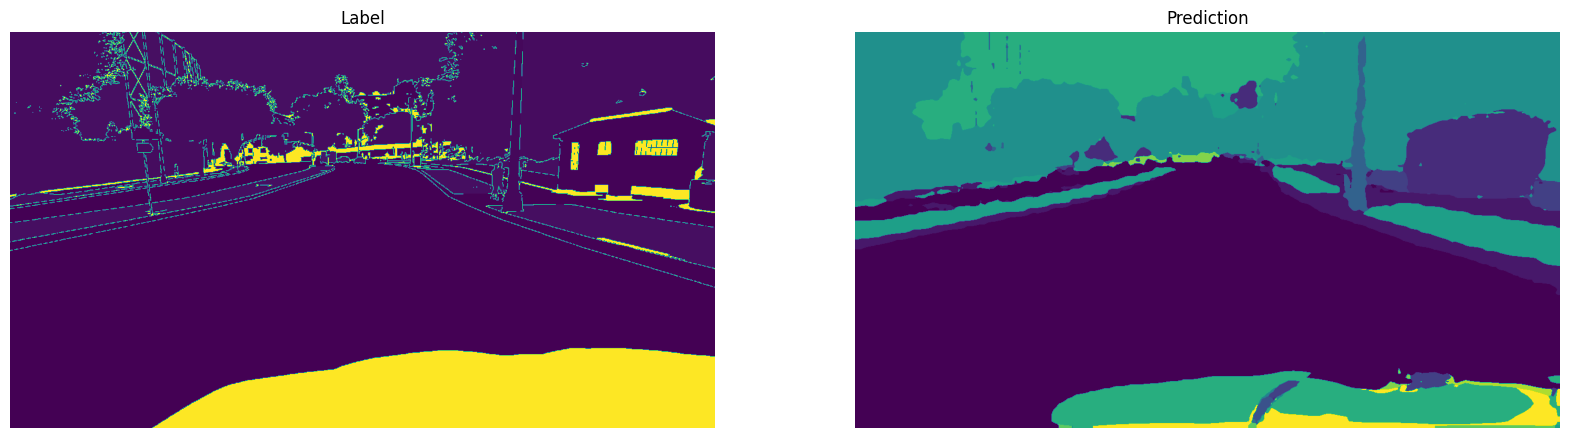

In [14]:
# Get the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_step3b/bisenet_gta5_aug_1.pth'))
# Set model to evaluation mode
model.eval()

# Load the dataset
# Load the dataset
dataset = GTA5(root_dir='datasets/GTA5')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

for i, (image, label) in tqdm(enumerate(dataloader)):
    # Move the data to the device
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # Compute the predictions
    pred = output.argmax(dim=1)
    # Stop after the first iteration
    break

# Display the image
image = ToPILImage()(image[0].cpu())
# Convert label, pred from numpy to image
label = Image.fromarray(label[0].cpu().numpy().astype(np.uint8))
pred = Image.fromarray(pred[0].cpu().numpy().astype(np.uint8))

# Display the image
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(label)
plt.title('Label')
plt.axis('off')
plt.subplot(122)
plt.imshow(pred)
plt.title('Prediction')
plt.axis('off')
plt.show()

### Evaluation (CityScapes) - Augmentation 1

In [6]:
# These are the class labels for the Cityscapes dataset
class_labels = {
    0: 'road',
    1: 'sidewalk',
    2: 'building',
    3: 'wall',
    4: 'fence',
    5: 'pole',
    6: 'traffic light',
    7: 'traffic sign',
    8: 'vegetation',
    9: 'terrain',
    10: 'sky',
    11: 'person',
    12: 'rider',
    13: 'car',
    14: 'truck',
    15: 'bus',
    16: 'train',
    17: 'motorcycle',
    18: 'bicycle'
}

In [7]:
# Get the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_step3b/bisenet_gta5_aug_1.pth'))
# Set model to evaluation mode
model.eval()

## Get the miou for the Cityscapes dataset in the validation split
# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=6)

# Evaluate the model
hist = np.zeros((19, 19))
for i, (images, labels) in enumerate(tqdm(dataloader)):
    # Move the data to the device
    images = images.to(device)
    label = labels.to(device)
    # Forward pass
    output = model(images)[0]
    # Compute the predictions
    pred = output.argmax(dim=0)

    # Calculate the mean IoU
    hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
    
# Calculate the mean IoU
miou = np.mean(per_class_iou(hist))
print(f"Mean IoU: {miou:.4f} \n")

class_ious = per_class_iou(hist)
# Print per-class IoU
for i, iou in enumerate(class_ious):
    print(f"{class_labels[i]} IoU: {iou:.4f}")

100%|██████████| 500/500 [00:06<00:00, 80.14it/s]

Mean IoU: 0.2527 

road IoU: 0.6167
sidewalk IoU: 0.2609
building IoU: 0.6657
wall IoU: 0.1538
fence IoU: 0.0886
pole IoU: 0.1481
traffic light IoU: 0.0768
traffic sign IoU: 0.0141
vegetation IoU: 0.7695
terrain IoU: 0.2781
sky IoU: 0.5932
person IoU: 0.3518
rider IoU: 0.0488
car IoU: 0.4405
truck IoU: 0.1386
bus IoU: 0.1047
train IoU: 0.0175
motorcycle IoU: 0.0340
bicycle IoU: 0.0000


### Evaluation (CityScapes) - Augmentation 2

In [8]:
# Get the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_step3b/bisenet_gta5_aug_2.pth'))
# Set model to evaluation mode
model.eval()

## Get the miou for the Cityscapes dataset in the validation split
# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=6)

# Evaluate the model
hist = np.zeros((19, 19))
for i, (images, labels) in enumerate(tqdm(dataloader)):
    # Move the data to the device
    images = images.to(device)
    label = labels.to(device)
    # Forward pass
    output = model(images)[0]
    # Compute the predictions
    pred = output.argmax(dim=0)

    # Calculate the mean IoU
    hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
    
# Calculate the mean IoU
miou = np.mean(per_class_iou(hist))
print(f"Mean IoU: {miou:.4f} \n")

class_ious = per_class_iou(hist)
# Print per-class IoU
for i, iou in enumerate(class_ious):
    print(f"{class_labels[i]} IoU: {iou:.4f}")

100%|██████████| 500/500 [00:06<00:00, 77.71it/s]

Mean IoU: 0.2265 

road IoU: 0.7973
sidewalk IoU: 0.2423
building IoU: 0.6251
wall IoU: 0.1491
fence IoU: 0.0249
pole IoU: 0.1233
traffic light IoU: 0.0722
traffic sign IoU: 0.0125
vegetation IoU: 0.6872
terrain IoU: 0.1693
sky IoU: 0.5298
person IoU: 0.1539
rider IoU: 0.0000
car IoU: 0.5990
truck IoU: 0.1054
bus IoU: 0.0109
train IoU: 0.0007
motorcycle IoU: 0.0000
bicycle IoU: 0.0000


### Evaluation (CityScapes) - Augmentation 3

In [9]:
# Get the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_step3b/bisenet_gta5_aug_3.pth'))
# Set model to evaluation mode
model.eval()

## Get the miou for the Cityscapes dataset in the validation split
# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=6)

# Evaluate the model
hist = np.zeros((19, 19))
for i, (images, labels) in enumerate(tqdm(dataloader)):
    # Move the data to the device
    images = images.to(device)
    label = labels.to(device)
    # Forward pass
    output = model(images)[0]
    # Compute the predictions
    pred = output.argmax(dim=0)

    # Calculate the mean IoU
    hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
    
# Calculate the mean IoU
miou = np.mean(per_class_iou(hist))
print(f"Mean IoU: {miou:.4f} \n")

class_ious = per_class_iou(hist)
# Print per-class IoU
for i, iou in enumerate(class_ious):
    print(f"{class_labels[i]} IoU: {iou:.4f}")

100%|██████████| 500/500 [00:06<00:00, 80.15it/s]

Mean IoU: 0.2290 

road IoU: 0.8226
sidewalk IoU: 0.2706
building IoU: 0.6528
wall IoU: 0.1361
fence IoU: 0.0521
pole IoU: 0.0908
traffic light IoU: 0.0001
traffic sign IoU: 0.0003
vegetation IoU: 0.7294
terrain IoU: 0.2318
sky IoU: 0.4688
person IoU: 0.1071
rider IoU: 0.0001
car IoU: 0.6313
truck IoU: 0.1467
bus IoU: 0.0105
train IoU: 0.0000
motorcycle IoU: 0.0000
bicycle IoU: 0.0000


### Evaluation (CityScapes) - Augmentation 4

In [10]:
# Get the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_step3b/bisenet_gta5_aug_4.pth'))
# Set model to evaluation mode
model.eval()

## Get the miou for the Cityscapes dataset in the validation split
# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=6)

# Evaluate the model
hist = np.zeros((19, 19))
for i, (images, labels) in enumerate(tqdm(dataloader)):
    # Move the data to the device
    images = images.to(device)
    label = labels.to(device)
    # Forward pass
    output = model(images)[0]
    # Compute the predictions
    pred = output.argmax(dim=0)

    # Calculate the mean IoU
    hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
    
# Calculate the mean IoU
miou = np.mean(per_class_iou(hist))
print(f"Mean IoU: {miou:.4f} \n")

class_ious = per_class_iou(hist)
# Print per-class IoU
for i, iou in enumerate(class_ious):
    print(f"{class_labels[i]} IoU: {iou:.4f}")

100%|██████████| 500/500 [00:06<00:00, 78.04it/s]

Mean IoU: 0.2281 

road IoU: 0.6082
sidewalk IoU: 0.1765
building IoU: 0.6102
wall IoU: 0.1625
fence IoU: 0.1177
pole IoU: 0.0663
traffic light IoU: 0.0612
traffic sign IoU: 0.0427
vegetation IoU: 0.7640
terrain IoU: 0.2321
sky IoU: 0.6193
person IoU: 0.2023
rider IoU: 0.0373
car IoU: 0.4343
truck IoU: 0.1269
bus IoU: 0.0719
train IoU: 0.0007
motorcycle IoU: 0.0000
bicycle IoU: 0.0000


### Example

0it [00:00, ?it/s]


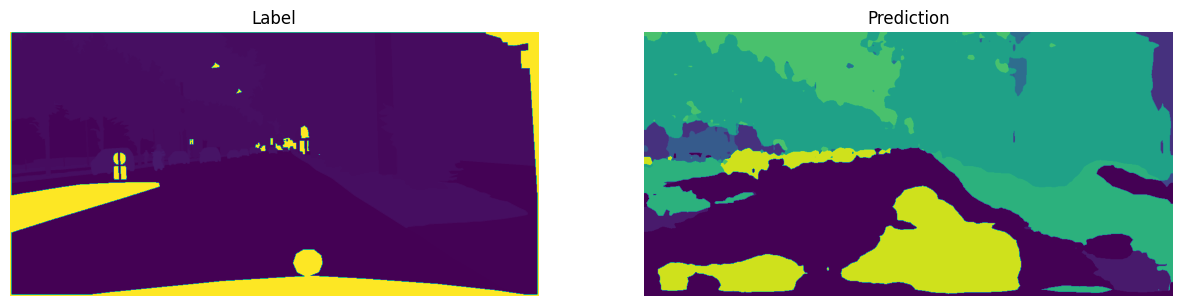

In [11]:
## Inference
# Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_step3b/bisenet_gta5_aug_4.pth'))
# Set model to evaluation mode
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

for i, (image, label) in tqdm(enumerate(dataloader)):
    # Move the data to the device
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # Compute the predictions
    pred = output.argmax(dim=1)
    # Stop after the first iteration
    break

# Display the image
image = ToPILImage()(image[0].cpu())
# Convert label, pred from numpy to image
label = Image.fromarray(label[0].cpu().numpy().astype(np.uint8))
pred = Image.fromarray(pred[0].cpu().numpy().astype(np.uint8))

# Display the image
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(label)
plt.title('Label')
plt.axis('off')
plt.subplot(122)
plt.imshow(pred)
plt.title('Prediction')
plt.axis('off')
plt.show()